In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series
from tslearn.utils import to_time_series_dataset
from tslearn.datasets import UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans

In [2]:
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [3]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')

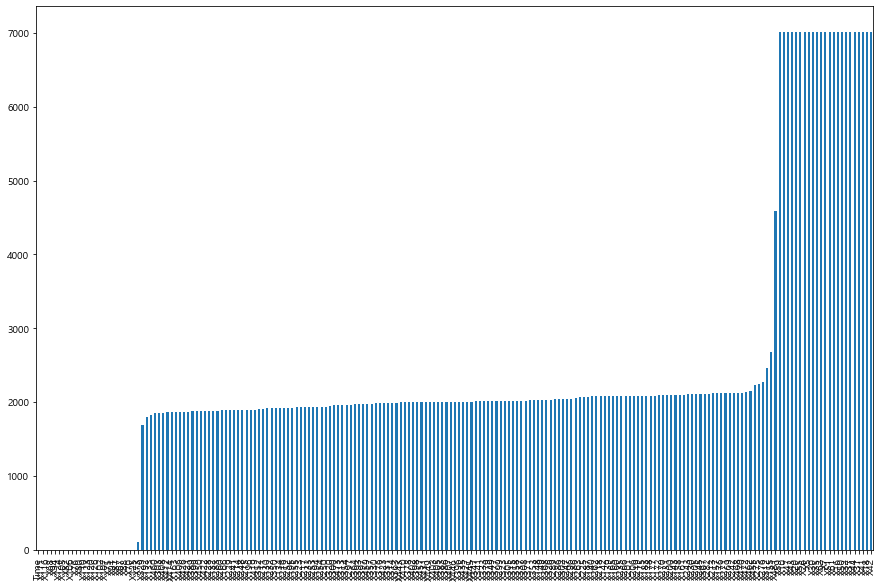

In [5]:
# 결측치 갯수 시각화
test.isnull().sum().sort_values(ascending=True).plot(kind='bar',figsize=(15,10))

In [6]:
##### train 결측치 채우기

> 직전시간대의 전력수요량이 과다측정된경우의 결측값 처리

In [7]:
for k in range(1,len(train.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    train_median=train.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=train.loc[ train.iloc[:,k].isnull()==False ][ train.columns[k] ].index

    df=pd.DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )
    
    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if train.iloc[i,k]>=train_median: #현재 index에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            train.iloc[ i : i+j+1 , k] = train.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:
            pass
            #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

50 번째 실행중
100 번째 실행중
150 번째 실행중
200 번째 실행중
250 번째 실행중
300 번째 실행중
350 번째 실행중
400 번째 실행중
450 번째 실행중
500 번째 실행중
550 번째 실행중
600 번째 실행중
650 번째 실행중
700 번째 실행중
750 번째 실행중
800 번째 실행중
850 번째 실행중
900 번째 실행중
950 번째 실행중
1000 번째 실행중
1050 번째 실행중
1100 번째 실행중
1150 번째 실행중
1200 번째 실행중
1250 번째 실행중
1300 번째 실행중


In [8]:
for k in range(1,len(test.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    test_median=test.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=test.loc[ test.iloc[:,k].isnull()==False ][ test.columns[k] ].index

    df=pd.DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )
    
    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if test.iloc[i,k]>=test_median: #현재 indetestx에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            test.iloc[ i : i+j+1 , k] = test.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:
            pass
            #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

50 번째 실행중
100 번째 실행중
150 번째 실행중
200 번째 실행중


In [9]:
train['Time'] = train['Time'].apply(pd.to_datetime)
train.set_index('Time',inplace=True)

test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

> 1,2차 결측치 처리 후 온전한 데이터인 2/15일 이후 부터의 데이터로 모델링 진행

In [10]:
train_sample = train['2018-02-15':]
train_sample = train_sample.interpolate(method='time')

test_sample = test['2018-02-15':]
test_sample = test_sample.interpolate(method='time')

In [11]:
#결측값 가진 행 제거 - 데이터가 아예 없는 경우
train_sample.loc[:,train_sample.isnull().sum() >= 1].columns

Index(['X4', 'X127', 'X9', 'X65', 'X54', 'X13', 'X53', 'X24', 'X17', 'X14',
       'X48', 'X2', 'X19', 'X36', 'X28', 'X63', 'X38', 'X39', 'X8', 'X64',
       'X29', 'X57', 'X705', 'X71', 'X3', 'X27', 'X22', 'X21', 'X118', 'X6',
       'X45', 'X40', 'X66', 'X52', 'X12', 'X49', 'X1', 'X33', 'X60', 'X46',
       'X963', 'X56', 'X15', 'X11', 'X25', 'X34', 'X23', 'X58'],
      dtype='object')

In [12]:
#결측값 가진 행 제거 - 데이터가 아예 없는 경우
test_sample.loc[:,test_sample.isnull().sum() >= 1].columns

Index(['X26', 'X16', 'X7', 'X18', 'X41', 'X55', 'X5', 'X43', 'X59', 'X10',
       'X62', 'X61', 'X32', 'X31', 'X30', 'X51', 'X35', 'X44', 'X37', 'X42',
       'X50', 'X47', 'X20'],
      dtype='object')

In [13]:
train_sample.drop(['X4', 'X127', 'X9', 'X65', 'X54', 'X13', 'X53', 'X24', 'X17', 'X14',
       'X48', 'X2', 'X19', 'X36', 'X28', 'X63', 'X38', 'X39', 'X8', 'X64',
       'X29', 'X57', 'X705', 'X71', 'X3', 'X27', 'X22', 'X21', 'X118', 'X6',
       'X45', 'X40', 'X66', 'X52', 'X12', 'X49', 'X1', 'X33', 'X60', 'X46',
       'X963', 'X56', 'X15', 'X11', 'X25', 'X34', 'X23', 'X58'], axis=1, inplace=True)

test_sample.drop(['X26', 'X16', 'X7', 'X18', 'X41', 'X55', 'X5', 'X43', 'X59', 'X10',
       'X62', 'X61', 'X32', 'X31', 'X30', 'X51', 'X35', 'X44', 'X37', 'X42',
       'X50', 'X47', 'X20'],axis=1,inplace=True)

> 시계열 패턴 분류 및 분석을 위한 데이터 전처리 <br>
> tslearn 패키지 사용 kmeans.cluster 사용

In [14]:
tmp_list = []

for i in range(len(train_sample.columns)):
    tmp_list.append(train_sample.iloc[:,i].values)

to_formatted = np.array(tmp_list)

formatted = to_time_series_dataset(to_formatted)

In [15]:
# tslearn input data
formatted.shape

(1252, 3264, 1)

> train_sample 데이터를 10개의 군집으로 분류

In [16]:
km = TimeSeriesKMeans(n_clusters=10,verbose=True,n_init=10,random_state=0)
y_pred = km.fit_predict(formatted)

Init 1
248.286 --> 167.315 --> 162.079 --> 160.984 --> 160.588 --> 160.259 --> 160.021 --> 159.866 --> 159.805 --> 159.767 --> 159.740 --> 159.724 --> 159.716 --> 159.712 --> 159.711 --> 159.710 --> 159.710 --> 
Init 2
254.454 --> 181.319 --> 176.362 --> 175.428 --> 174.889 --> 174.623 --> 174.470 --> 174.366 --> 174.272 --> 174.093 --> 173.105 --> 171.588 --> 170.854 --> 170.502 --> 170.298 --> 170.074 --> 169.921 --> 169.799 --> 169.739 --> 169.716 --> 169.684 --> 169.660 --> 169.633 --> 169.602 --> 169.578 --> 169.543 --> 169.500 --> 169.478 --> 169.461 --> 169.451 --> 169.442 --> 169.430 --> 169.418 --> 169.412 --> 169.404 --> 169.397 --> 169.391 --> 169.382 --> 169.373 --> 169.363 --> 169.349 --> 169.342 --> 169.339 --> 169.336 --> 169.334 --> 169.334 --> 169.334 --> 
Init 3
264.931 --> 186.308 --> 184.771 --> 183.943 --> 182.191 --> 180.594 --> 178.526 --> 177.178 --> 176.898 --> 176.717 --> 176.674 --> 176.647 --> 176.637 --> 176.633 --> 176.629 --> 176.628 --> 176.628 --> 
Init

> 분류된 trains_sample 데이터의 군집별 패턴 파악

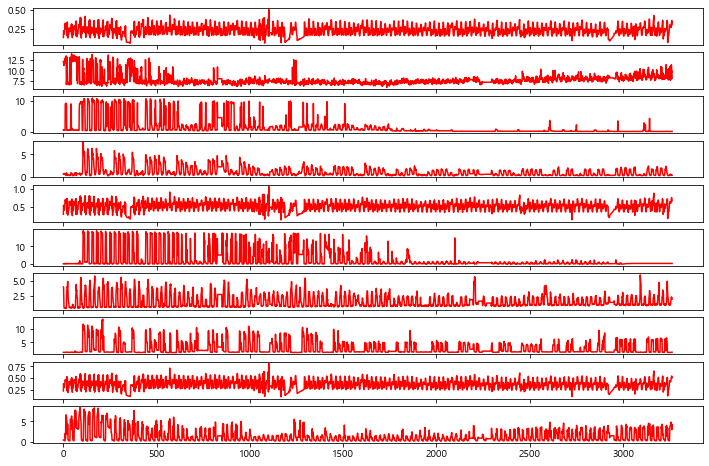

In [17]:
plt.figure(figsize=(12,8))
for yi in range(10):
    plt.subplot(10,1, yi+1)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")

In [18]:
# predict = pd.DataFrame(km.predict(formatted))
# predict.columns=['predict']

In [19]:
data = {'target' : train_sample.columns,
       'cluster' : km.predict(formatted)
       }

cluster_frame = pd.DataFrame(data)

In [20]:
cluster_frame.head()

,target,cluster
0,X692,8
1,X1272,8
2,X553,4
3,X1299,0
4,X598,0


In [21]:
# 군집별 갯수 파악
cluster_frame.groupby('cluster').size()

cluster
0    365
1      1
2      1
3     12
4    249
5      1
6      2
7      1
8    618
9      2
dtype: int64

> 0 군집을 대상으로 모델링 진행

In [22]:
cluster_0 = cluster_frame[cluster_frame.cluster ==0]['target'].values

> train_sample의 패턴별 군집에 맞추어 test 세대를 군집 분류 <br>
> train세대와 test세대는 서로 다른 세대임(중복x)

In [23]:
## cluster test set

In [24]:
tmp_test_list = []

for i in range(len(test_sample.columns)):
    tmp_test_list.append(test_sample.iloc[:,i].values)

to_test_formatted = np.array(tmp_test_list)

test_formatted = to_time_series_dataset(to_test_formatted)

In [25]:
data = {'target' : test_sample.columns,
       'cluster' : km.predict(test_formatted)
       }

cluster_test_frame = pd.DataFrame(data)

In [26]:
cluster_test_frame.head()

,target,cluster
0,X303,4
1,X241,0
2,X435,8
3,X402,8
4,X352,0


In [27]:
# 군집별 개수 파악
cluster_test_frame.groupby('cluster').size()

cluster
0    92
1     1
3    11
4    15
7     1
8    57
dtype: int64

In [28]:
cluster_test_0 = cluster_test_frame[cluster_test_frame.cluster == 0]['target'].values

In [29]:
# 0,1,3,4,7,8 군집별 모델 생성

In [30]:
# RNN 네트워크에 input 형식으로 넣기위한 과정 
# RNN의 input shape은 (timestep,feature)

def to_X_train(target):
    
    train_sc_df = pd.DataFrame(target , columns=['Scaled'], index=train_sample.index)
    for s in range(1, 7):
        train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    X_train = train_sc_df.dropna().drop('Scaled', axis=1)
    y_train = train_sc_df.dropna()[['Scaled']]    
    X_train = X_train.values
    y_train = y_train.values
    
    X_train_s = X_train.reshape(X_train.shape[0], 6, 1) # 6 기간의 시간씩, feature는 전력수요량 1차원
    return X_train_s,y_train 
    

In [31]:
ss = []
for idx,k in enumerate(cluster_0):
    x,y = to_X_train(train_sample[k].values)
    ss.append([x,y])

In [32]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 
K.clear_session()

model = Sequential() # Sequeatial Model 
model.add(LSTM(32, input_shape=(6, 1),return_sequences=True)) # (timestep, feature)
# model.add(Dropout(0.1)) # overfitting을 막기 위해 10% 가량 drop
model.add(LSTM(32, input_shape=(6, 1))) # (timestep, feature)
# model.add(Dropout(0.1)) # overfitting을 막기 위해 10% 가량 drop
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 32)             4352      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [33]:
# 모델 학습
early_stop = EarlyStopping(monitor='loss', patience=7, verbose=1)

for i in range(5):
    model.fit(ss[i][0],ss[i][1], epochs=30, batch_size=52, verbose=1, callbacks=[early_stop])


Epoch 1/30
3258/3258 [==============================] - 2s 651us/step - loss: 0.0333
Epoch 2/30
3258/3258 [==============================] - 1s 203us/step - loss: 0.0226
Epoch 3/30
3258/3258 [==============================] - 1s 212us/step - loss: 0.0208
Epoch 4/30
3258/3258 [==============================] - 1s 208us/step - loss: 0.0194
Epoch 5/30
3258/3258 [==============================] - 1s 210us/step - loss: 0.0188
Epoch 6/30
3258/3258 [==============================] - 1s 202us/step - loss: 0.0183
Epoch 7/30
3258/3258 [==============================] - 1s 198us/step - loss: 0.0182
Epoch 8/30
3258/3258 [==============================] - 1s 215us/step - loss: 0.0179
Epoch 9/30
3258/3258 [==============================] - 1s 183us/step - loss: 0.0181
Epoch 10/30
3258/3258 [==============================] - 1s 208us/step - loss: 0.0178
Epoch 11/30
3258/3258 [==============================] - 1s 219us/step - loss: 0.0175
Epoch 12/30
3258/3258 [==============================] - 1s 20

3258/3258 [==============================] - 1s 199us/step - loss: 0.0164
Epoch 17/30
3258/3258 [==============================] - 1s 197us/step - loss: 0.0165
Epoch 18/30
3258/3258 [==============================] - 1s 198us/step - loss: 0.0167
Epoch 19/30
3258/3258 [==============================] - 1s 195us/step - loss: 0.0167
Epoch 20/30
3258/3258 [==============================] - 1s 204us/step - loss: 0.0166
Epoch 21/30
3258/3258 [==============================] - 1s 195us/step - loss: 0.0166
Epoch 22/30
3258/3258 [==============================] - 1s 205us/step - loss: 0.0165
Epoch 23/30
3258/3258 [==============================] - 1s 199us/step - loss: 0.0164
Epoch 00023: early stopping
Epoch 1/30
3258/3258 [==============================] - 1s 196us/step - loss: 0.0054
Epoch 2/30
3258/3258 [==============================] - 1s 199us/step - loss: 0.0052
Epoch 3/30
3258/3258 [==============================] - 1s 200us/step - loss: 0.0051
Epoch 4/30
3258/3258 [===================

In [34]:
def to_X_test(target):
    
    test_sc_df = pd.DataFrame(target , columns=['Scaled'], index=test_sample.index)
    for s in range(1, 7):
        test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)
    X_test = test_sc_df.dropna().drop('Scaled', axis=1)
    y_test = test_sc_df.dropna()[['Scaled']]    
    X_test = X_test.values
    y_test = y_test.values
    
    X_test_t = X_test.reshape(X_test.shape[0], 6, 1)
    return X_test_t,y_test

In [35]:
ss_test = []
for idx,k in enumerate(cluster_test_0):
    x,y = to_X_test(test_sample[k].values)
    ss_test.append([x,y])

In [43]:
y_pred = model.predict(ss_test[1][0])
print(y_pred)

[[0.09487619]
 [0.08623376]
 [0.08568147]
 ...
 [0.21115771]
 [0.19647005]
 [0.25871256]]


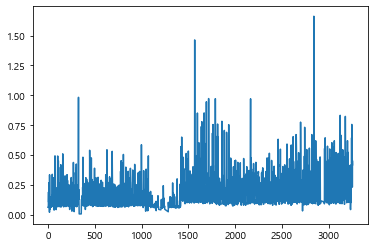

In [44]:
plt.figure()
plt.plot(ss_test[1][1])

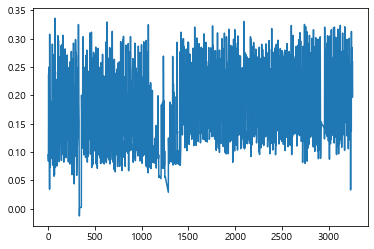

In [45]:
plt.figure()
plt.plot(y_pred)

# 1. 문제의 정의

> 시계열 데이터를 활용한 예측 모델링을 구현하는 문제이다 <br>
> 주어진 시계열 데이터를 사용할 모델의 형식에 맞추어 처리한 후 모델들중 가장 성능이 우수한 모델을 채택하였다. <br>
> 사용한 모델은 SMA,WMA,HOLT,ARIMA등 전통적 시계열 분석 기법과 RNN 기법 등 최대한 많은 모델을 직접 다루어 본다. <br>
> 어떤 Feature, 즉 전력수요량에 영향을 미치는 요소를 찾아내는것과 그 요소를 모델링에 반영하는것이 중요한 과제이다.
> 이 문제에서 특이한 점은 <b>첫째,</b> 결측값이 굉장히 많다.(본문 그래프 참조) 따라서 결측값을 어떻게 다룰것인가 또한 중요한 변수이다. <br> <b>둘째,</b> Train과 Test에서의 예측되어야하는 세대가 다르다는점이다. 즉, A세대의 수요량 예측모델을 활용하여 B세대의 수요량을 예측해야한다.

<br>

# 2. 데이터 탐색

>  주어진 데이터는 인천시 소재 1300세대의 2016/07/20 ~ 2018/06/30까지 시간당 전력수요량 데이터(Trian)와 2017/07/01~2018/06/30까지의 인천시 소재 200세대의 시간당 전력 수요량 데이터(Test)로 구성되어있다. 앞서 말한것처럼 Train의 1300세대와 Test의 200세대는 서로 겹치지 않는 다른 세대이다.

> 첫번째 특이점으로 지적하였던, 다수의 결측값에대한 고민이 필요하다. 결측값의 경우 크게, <br>
>  <b> 1. 미터링 시스템 부재에 의한 결측치 </b> <br>
>  <b> 2. 직전 시간대 전력 사용량 값이 높아 이후 값들이 결측치가 되는 문제 (미터링 데이터 수집 시스템의 특징) 두가지로 볼 수 있다.</b> <br>

>직전 시간대 과대사용에 의한 결측값의 경우, 해당 세대의 전체 수요량 평균값에 비해 관측치가 지나치게 큰 구간을 파악하여 이후의 값이 결측값이면 두번째 요인에 의한 결측값이라 판단, 결측구간을 직전과대값/결측구간 길이의 값으로 결측값을 채워 넣었다.
<br>

> 주어진 데이터에는 각기 다른 총 1500세대의 2년간 전력수요량 데이터가 존재한다. 1500세대(아파트 or 상가)는 각 세대만의 수요패턴을 갖고있을것이라는 생각을 해보았다. 예를들어, A세대는 주말에만 수요량이 높아지는 경향, B세대는 월,금에 수요량이 높아지는 경향등 세대별로 다양한 전력수요 패턴을 가질것이다. 따라서 예측 모델링 이전에 <b> 시간단위 전력사용량에 대한 시계열 패턴의 군집 및 분류분석</b>이 선행되어야 한다고 생각하였다.


# 3. 모델링

> 모델링의 경우 시계열 분석기법 전반에 대한 학습을 위해 가능한 모델들을 모두 사용해 본 뒤 가장 성능이 우수한 모델을 채택하였다.
> 결과적으로 가장 성능이 우수했던 RNN기반 모델의 프로세스는 아래와 같다
> 1. 세대별 수요 패턴에 따른 군집 분류 (Train 1300세대에 대한)
> 2. 군집별 모델 생성 및 학습
> 3. Test 200세대를 Train 1300세대의 군집에 맞추어 분류
> 4. Test 200세대의 군집별 예측

# 4. 나는 프로젝트를 통해 무엇을 배우고 느꼈는가
> 연습용 데이터셋이나 캐글의 가이드라인이 있는 데이터분석 문제가 아닌 스스로의 능력으로 진행해본 프로젝트는 처음이다. 아직 100%의 완성을 시키지 못했고 만족도 또한 높지 않지만 스스로 진행하며 느낀점과 성장도는 매우 높다고 생각한다. 느낀점을 정리해보자면, <br><br>
> <b>첫째,</b> 계획없는 분석은 산으로가는 지름길이라는 점이다. 데이터를 무작정 다루어보기 보다는, 반드시 내가 해결해야하는 과제를 정확히 파악한 후 탑다운 방식으로 최종 산출물을 그려보는 접근법이 필요하다는것을 절실히 느꼈다. 시작점과 끝점에 대한 명확한 기준이 설립되어야 중간 과정에서 온길을 되돌아가는 수고를 덜 수 있겠다른 생각이 절실히 들었다. <br><br>
> <b>둘째로,</b> 데이터를 모델링에 맞추는것이아닌 데이터에 맞는 모델링이 필요하다는것을 느꼈다. 연습용 데이터와 실제의 데이터는 당황스러울정도로 달랐다. 무자비한 결측값과 기존 상식과는 다른 상관관계는 보이는 중간 결과물들을 보며 데이터를 전처리하는 과정도 중요하지만 그것이 불가능한 경우에 유연한 모델링 능력 또한 반드시 필요한 능력일것이라는 생각이 들었다. <br><br>
> <b>마지막으로는,</b> 어려움을 겪더라도 실제로 데이터분석 프로젝트를 진행해보는 과정은 성장하는데 있어서 반드시 필요한 부분이라는점이다. 이번 프로젝트가시계열 데이터를 직접(예제 데이터가아닌) 다루어본 첫번째인데, 그 동안 책이나 예제를 통한 학습에서는 왜 저런 전처리과정과 prameter가 사용되는가에 대한 이해가 잘 되지 않았지만 실제 프로젝트를 진행하는동안 이해가 가지않던 부분이 명확히 이해되는 순간을 여럿 겪었다. 충분한 학습과 적절한 프로젝트의 병행은 성장을 위한 지름길이라는것을 다시한번 배울 수 있었다.


# 5. 이 프로젝트를 지속한다면, 다음 단계는 무엇인가?
> 앞서 말한데로, 이 프로젝트는 100% 완성된것이 아니다. 예측 모델링 부부은 어느정도 완성되었지만 이 예측모델을 활용하는 활용사례 까지 진행할 계획이다. 이 모델링 프로젝트의 의의는 <b>"각 세대,상가,건물별로의 세분화된 예측이 가능해짐"</b>에 있다. 기존의 전체를 다루는 수요예측이 아닌 사물인터넷,센서데이터를 활용한 더 정교하고 세분화된 예측이 가능해지는 것이다. <br>
> 각 세대,상가,건물별로의 전력수요량 예측이 가능해진다면 이는 세대별 맞춤 서비스 혹은 관리자(ex한국전력)의 입장에서는 target 맞춤 관리 시스템을 구현할 수 있다는 점이다. <b>예측모델을 통한 세대별 통합 수요관리시스템이 이 프로젝트의 최종 목표이다.</b>